# Install required packages

In [1]:
# Install gensim in Colab
!pip install gensim


We install Gensim, a Python library used for topic modeling, document similarity, and other NLP tasks.
It provides efficient implementations of algorithms like LDA (Latent Dirichlet Allocation) and Doc2Vec, which help in extracting hidden topics and semantic patterns from legal judgments.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Required Libraries

In [3]:
import os
import zipfile
import re
import nltk
import pandas as pd
import numpy as np
!pip install PyMuPDF tqdm
import fitz  # PyMuPDF
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel, Phrases
from gensim.models.phrases import Phraser
from gensim.models.coherencemodel import CoherenceModel

We import the necessary Python libraries for text preprocessing, topic modeling, and file handling.
These include modules for data manipulation (pandas, numpy), text cleaning (nltk, re), and topic modeling (gensim).
We also install and use PyMuPDF (fitz) for reading PDF files and tqdm for displaying progress bars during processing.

# Loading Data from Google Drive

In [4]:
# Paths on Google Drive
csv_path = '/content/drive/MyDrive/Indian_judgements/reduced_judgements_clean.csv'
pdf_zip_path = '/content/drive/MyDrive/Indian_judgements/reduced_pdfs.zip'

# Extract ZIP to a folder in Colab
extracted_pdf_dir = '/content/reduced_pdfs'
os.makedirs(extracted_pdf_dir, exist_ok=True)

with zipfile.ZipFile(pdf_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_pdf_dir)

print("PDFs extracted to:", extracted_pdf_dir)


PDFs extracted to: /content/reduced_pdfs


We import the necessary Python libraries for text preprocessing, topic modeling, and file handling.
These include modules for data manipulation (pandas, numpy), text cleaning (nltk, re), and topic modeling (gensim).
We also install and use PyMuPDF (fitz) for reading PDF files and tqdm for displaying progress bars during processing.

# Preparing Data

In [5]:
# Load CSV
df = pd.read_csv(csv_path)

# Paths for data
csv_path = '/content/drive/MyDrive/Indian_judgements/reduced_judgements_clean.csv'
pdf_dir = '/content/reduced_pdfs'  # extracted ZIP folder


df = pd.read_csv(csv_path)
print("CSV loaded successfully!")
print("Columns in CSV:", list(df.columns))
print("\nPreview:")
print(df.head())

# Update PDF paths
df['pdf_path'] = df['pdf_path'].apply(lambda x: os.path.join(pdf_dir, os.path.basename(str(x))))

CSV loaded successfully!
Columns in CSV: ['diary_no', 'case_no', 'judgment_dates', 'pdf_exists', 'pdf_path']

Preview:
     diary_no                          case_no judgment_dates  pdf_exists  \
0  80384-1991                              - 0     10-03-1992        True   
1  18732-1998  Crl.A. No.-001258-001263 - 1999     26-11-1999        True   
2   7011-2000    C.A. No.-002551-002551 - 2001     20-02-2008        True   
3  25859-2004    C.A. No.-000584-000584 - 2008     22-01-2008        True   
4   9232-2003    C.A. No.-004227-004227 - 2003     03-09-2009        True   

                                            pdf_path  
0  /content/indian_judgments/pdfs/80384-1991___jo...  
1  /content/indian_judgments/pdfs/18732-1998___jo...  
2  /content/indian_judgments/pdfs/7011-2000___jon...  
3  /content/indian_judgments/pdfs/25859-2004___jo...  
4  /content/indian_judgments/pdfs/9232-2003___jon...  


The CSV file (reduced_judgements_clean.csv) is then read into a Pandas DataFrame, which contains structured information such as diary numbers, case details, and judgment text. Finally, the script displays the column names and a preview of the first few rows to ensure that the data has been successfully loaded and is ready for processing.

# Extracting Text from Judgment PDFs

In [7]:

# Extract text from PDFs
df['judgements_text'] = ''

# Filter to only existing & non-empty PDFs
df = df[df['pdf_path'].apply(lambda x: os.path.exists(x) and os.path.getsize(x) > 0)].reset_index(drop=True)
print("Total valid PDFs found:", len(df))

# Extract text from PDFs
for i, row in tqdm(df.iterrows(), total=len(df), desc="Extracting text"):
    pdf_path = row['pdf_path']
    text = ''
    try:
        with fitz.open(pdf_path) as doc:
            for page in doc:
                page_text = page.get_text()
                if page_text:
                    text += page_text + '\n'
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
    df.at[i, 'judgements_text'] = text

print("\n Text extraction done for", len(df), "PDFs")

text_csv_path = '/content/judgements_with_text.csv'

df.to_csv(text_csv_path, index=False)
df.to_parquet(text_parquet_path, index=False)

print(f"Saved extracted data to:\nCSV: {text_csv_path}")


Total valid PDFs found: 1879


Extracting text: 100%|██████████| 1879/1879 [01:28<00:00, 21.32it/s]



 Text extraction done for 1879 PDFs
Saved extracted data to:
CSV: /content/judgements_with_text.csv


This section extracts the textual content from each judgment PDF and saves it for further processing.
First, the code updates the file paths to correctly point to the extracted PDF directory and filters out any missing or empty files. It then iterates through each valid PDF using PyMuPDF (fitz), reading all pages and concatenating their text into a single string. The extracted text is stored in a new column called judgements_text within the DataFrame.
Finally, the complete dataset—containing both metadata and the extracted text—is saved in CSV for future use.

# Text Preprocessing and Chunking

In [8]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize stopwords with English + legal words + modals
stop_words = set(stopwords.words('english'))
legal_stopwords = {
    'petitioner', 'respondent', 'appellant', 'defendant', 'plaintiff',
    'party', 'parties', 'counsel', 'advocate', 'attorney', 'prosecutor', 'applicant',
    'court', 'bench', 'judgment', 'order', 'proceedings', 'hearing', 'case',
    'matter', 'petition', 'claim', 'verdict', 'decision',
    'filed', 'plea', 'petitioners', 'respondents', 'submitted', 'allowed',
    'dismissed', 'granted', 'rejected', 'challenged', 'reviewed', 'appeal',
    'rights', 'regulation', 'rule', 'statute', 'provision', 'authority',
    'liable', 'responsible', 'application', 'objection', 'record'
    'shall', 'may', 'would', 'could', 'should', 'must', 'might'
}
stop_words.update(legal_stopwords)

lemmatizer = WordNetLemmatizer()
CHUNK_WORDS = 400
OVERLAP = 50

# Preprocess text
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = re.sub(r'(\w)-(\w)', r'\1 \2', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    tokens = text.split()
    tokens = [w for w in tokens if not w[0].isupper()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens if w.lower() not in stop_words and len(w) > 2]
    tokens = [w for w in tokens if re.fullmatch(r'[a-z]+', w)]

    return ' '.join(tokens)

# Apply preprocessing
df['processed_text'] = df['judgements_text'].apply(preprocess_text)

# Create overlapping chunks
def chunk_text_sliding_words(text, chunk_size=CHUNK_WORDS, overlap=OVERLAP):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return []
    words = text.split()
    if len(words) <= chunk_size:
        return [" ".join(words)]
    chunks = []
    start = 0
    while start < len(words):
        end = min(start + chunk_size, len(words))
        chunks.append(" ".join(words[start:end]))
        if end == len(words):
            break
        start += (chunk_size - overlap)
    return chunks

# Apply chunking
df['text_chunks'] = df['processed_text'].apply(chunk_text_sliding_words)
df_chunks = df.explode('text_chunks').reset_index(drop=True)
df_chunks = df_chunks[['diary_no', 'text_chunks']]
df_chunks = df_chunks[df_chunks['text_chunks'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)].reset_index(drop=True)

print("\n Preprocessing and chunking done!")

# Preview first 2 judgments
first_two_diary_nos = df_chunks['diary_no'].unique()[:2]
for diary_no in first_two_diary_nos:
    print(f"\n=== Chunks for Judgment {diary_no} ===\n")
    chunks = df_chunks[df_chunks['diary_no'] == diary_no]['text_chunks'].tolist()
    for i, chunk in enumerate(chunks, 1):
        print(f"--- Chunk {i} ({len(chunk.split())} words) ---")
        print(chunk[:500] + ("..." if len(chunk) > 500 else ""))
        print()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



 Preprocessing and chunking done!

=== Chunks for Judgment 80384-1991 ===

--- Chunk 1 (400 words) ---
qualification exercise jurisdiction ground incumbent fulfill qualification required dated appointed procedure officer administer justice power analogous judicial hold judicial office judiciary justice assume jurisdiction judicial side probe purely administrative nature exclusively within purview serviceinterpretation letter dated addressed recommended name appointment bio data enclosed said letter indicated passing joined worked various post law appointed worked also worked certain bio data desc...

--- Chunk 2 (400 words) ---
eligible appointed mockery hold eligible appointed scheme clear independence judiciary part basic structure achieve objective separation judiciary executive framer meant judicial office exist independently duty part duty conferred person whether trained administration justice enshrined give mandate shall take step separate judiciary executive mean shall separat

This section prepares the extracted judgment text for topic modeling by cleaning, normalizing, and segmenting it into manageable chunks.
First, essential NLTK resources are downloaded to enable tokenization, stopword removal, and lemmatization. A custom set of legal stopwords is added to remove frequently occurring legal terms that do not contribute to topic meaning. The preprocess_text() function cleans the text by removing numbers, punctuation, uppercase legal terms, and extra spaces, while converting all words to lowercase and lemmatizing them to their root forms.
After cleaning, the text is divided into overlapping word chunks using the chunk_text_sliding_words() function. This ensures that large legal documents are split into smaller, context-preserving sections, making them suitable for efficient topic modeling and embedding generation.

# LDA Topic Modeling on Legal Texts

In [9]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import numpy as np

# Keep only non-empty string chunks
df_chunks = df_chunks[df_chunks['text_chunks'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)].reset_index(drop=True)

# Tokenize chunks
tokenized_texts = [chunk.split() for chunk in df_chunks['text_chunks']]

# Create bigrams (e.g., "service law", "tax liability") for more meaningful legal topics
bigram = Phrases(tokenized_texts, min_count=5, threshold=10)  # adjust threshold for phrase detection
bigram_mod = Phraser(bigram)
texts = [bigram_mod[doc] for doc in tokenized_texts]

# Create dictionary
dictionary = corpora.Dictionary(texts)

# Filter extremes: remove rare (<5 docs) and very common (>40% of docs) words
dictionary.filter_extremes(no_below=5, no_above=0.4)

# Convert texts to bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA model
NUM_TOPICS = 7
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=42,
    passes=30,      # more passes for better convergence
    chunksize=200,  # larger chunksize for efficiency
    alpha='auto',
    eta='auto'
)

# Print top words for each topic
for i, topic in lda_model.print_topics(num_words=15):
    print(f"--- Topic {i} ---")
    print(topic)
    print()

# Get topic distribution for each chunk
def get_topic_dist(bow):
    return [prob for _, prob in lda_model.get_document_topics(bow, minimum_probability=0)]

df_chunks['topic_dist'] = [get_topic_dist(bow) for bow in corpus]

# Aggregate topic distributions per judgment
agg_topic = df_chunks.groupby('diary_no')['topic_dist'].apply(lambda x: np.mean(np.vstack(x), axis=0))
df_judgment_topics = pd.DataFrame(agg_topic.tolist(), index=agg_topic.index, columns=range(NUM_TOPICS))
df_judgment_topics.reset_index(inplace=True)

# Normalize topic distributions
df_judgment_topics.iloc[:, 1:] = df_judgment_topics.iloc[:, 1:].div(df_judgment_topics.iloc[:, 1:].sum(axis=1), axis=0)

print("\nAggregated topic distributions per judgment:")
print(df_judgment_topics.head())


--- Topic 0 ---
0.041*"service" + 0.032*"employee" + 0.027*"post" + 0.025*"appointment" + 0.016*"year" + 0.015*"officer" + 0.014*"appointed" + 0.011*"candidate" + 0.008*"rule" + 0.008*"vacancy" + 0.007*"employer" + 0.007*"promotion" + 0.007*"work" + 0.007*"employment" + 0.007*"category"

--- Topic 1 ---
0.033*"land" + 0.032*"property" + 0.018*"suit" + 0.014*"possession" + 0.010*"right" + 0.009*"tenant" + 0.008*"owner" + 0.007*"area" + 0.007*"building" + 0.006*"rent" + 0.006*"interest" + 0.006*"share" + 0.006*"family" + 0.006*"decree" + 0.006*"entitled"

--- Topic 2 ---
0.006*"member" + 0.006*"public" + 0.004*"institution" + 0.004*"country" + 0.004*"process" + 0.004*"course" + 0.004*"need" + 0.003*"society" + 0.003*"reservation" + 0.003*"people" + 0.003*"like" + 0.003*"class" + 0.003*"principle" + 0.003*"conduct" + 0.003*"caste"

--- Topic 3 ---
0.013*"dated" + 0.008*"learned" + 0.007*"passed" + 0.006*"notice" + 0.006*"ground" + 0.005*"date" + 0.005*"issue" + 0.005*"issued" + 0.005*"per

In this section, we apply Latent Dirichlet Allocation (LDA) to discover hidden topics in the preprocessed judgment text.

Tokenization and Bigrams: Each text chunk is split into words, and common legal bigrams (e.g., "service law") are detected for better topic representation.

LDA Model Training: A global LDA model is trained on all chunks across all judgments to discover 7 recurring topics.

Per-Judgment Topic Distribution: Each judgment is split into chunks; the LDA model gives a topic distribution for each chunk, which is then averaged across chunks to get a single topic profile for the judgment.

# Mapping Topics to Law Categories

In [10]:
# Define target law categories (including Labor/Employment Law)
law_categories = {
    0: 'Administrative/Service Law',
    1: 'Civil Law',
    2: 'Constitutional Law',
    3: 'Labor/Employment Law',
    4: 'Criminal Law',
    5: 'Constitutional Law',
    6: 'Tax/Corporate Law'
}

# Map aggregated topic distributions to law categories
law_probs = []
for i, row in df_judgment_topics.iterrows():
    law_sum = {}
    for t in range(len(law_categories)):
        category = law_categories[t]
        law_sum[category] = law_sum.get(category, 0) + row[t]
    law_probs.append(law_sum)

# Convert to DataFrame
df_law_probs = pd.DataFrame(law_probs)

# Assign highest-probability category
df_judgment_topics['law_category'] = df_law_probs.idxmax(axis=1)

# Keep only diary_no and law_category
df_final = df_judgment_topics[['diary_no', 'law_category']].copy()

# Preview
print(df_final.head(10))

# Save to CSV
df_final.to_csv('/content/judgment_law_category_mapped.csv', index=False)


     diary_no                law_category
0          -0           Tax/Corporate Law
1       -1428  Administrative/Service Law
2      1-1148                   Civil Law
3      1-1918           Tax/Corporate Law
4      1-9098        Labor/Employment Law
5      1-9228          Constitutional Law
6    100-1961           Tax/Corporate Law
7  10044-2000        Labor/Employment Law
8  10045-2004          Constitutional Law
9  10049-1994        Labor/Employment Law


This step maps the LDA topic distributions to predefined law categories like Civil Law, Criminal Law, and Labor/Employment Law. For each judgment, the probabilities of topics in the same category are summed, and the category with the highest probability is assigned. The final results, containing diary_no and predicted law_category, are saved to a CSV for easy reference

# Visualization using Bar plot and Pie chart

/tmp/ipython-input-1884055544.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='Set2')


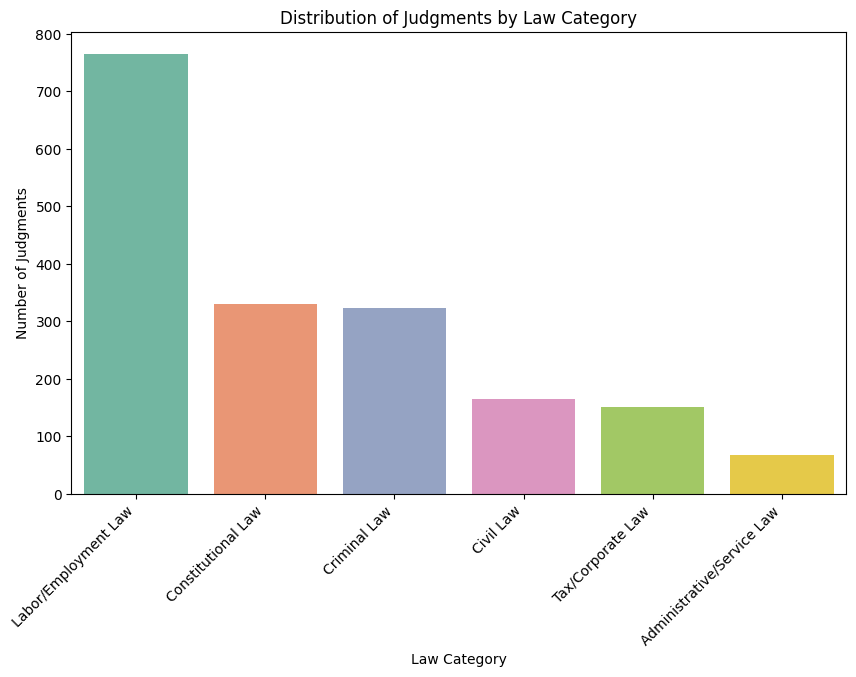

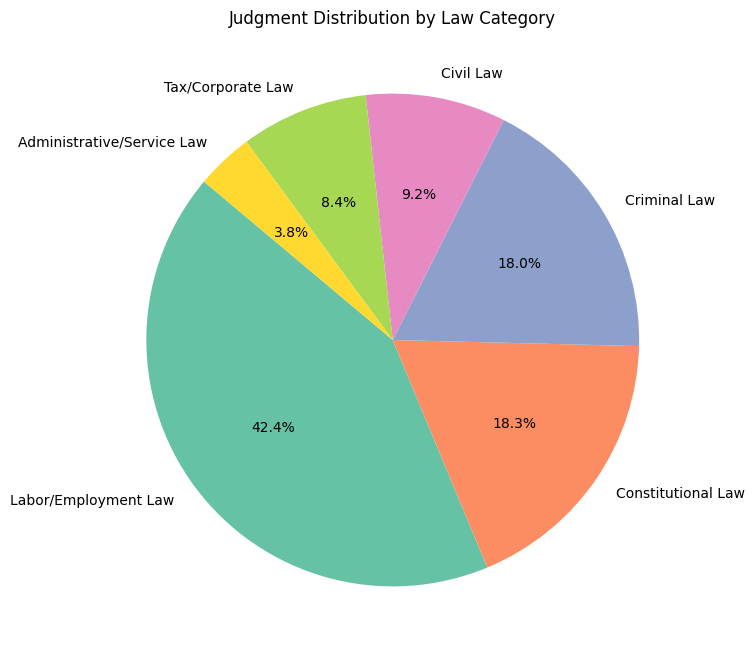

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count judgments per law category
category_counts = df_final['law_category'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='Set2')
plt.title("Distribution of Judgments by Law Category")
plt.ylabel("Number of Judgments")
plt.xlabel("Law Category")
plt.xticks(rotation=45, ha='right')
plt.show()
plt.figure(figsize=(8,8))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2", len(category_counts)))
plt.title("Judgment Distribution by Law Category")
plt.show()



The bar plot shows the number of judgments per category, and the pie chart shows the percentage share of each category, providing a quick overview of the dataset composition.

# t-SNE Visualization of Judgments

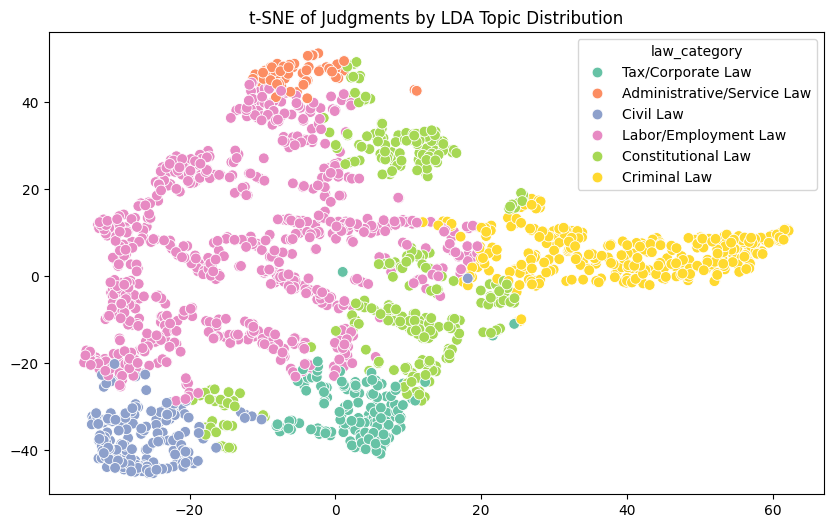

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# LDA topic vectors
X = df_judgment_topics[[i for i in range(NUM_TOPICS)]].values

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1],
                hue=df_final['law_category'], palette='Set2', s=60)
plt.title("t-SNE of Judgments by LDA Topic Distribution")
plt.show()


This code uses t-SNE to reduce the 7-dimensional LDA topic distributions to 2 dimensions for visualization. Each point represents a judgment, colored by its predicted law category, allowing us to visually explore how judgments cluster based on their topic profiles.

In [13]:
from gensim.models import CoherenceModel
import numpy as np

# Compute coherence scores for the LDA model
# texts: tokenized documents, dictionary: gensim dictionary, lda_model: trained LDA
coherence_cv = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
coherence_umass = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='u_mass').get_coherence()
coherence_npmi = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_npmi').get_coherence()

# Print coherence scores
print("LDA Coherence Scores:")
print(f"C_v (higher is better): {coherence_cv:.4f}")
print(f"UMass (closer to 0, higher is better, negative values expected): {coherence_umass:.4f}")
print(f"NPMI (higher is better): {coherence_npmi:.4f}")

# Compute perplexity (lower is better)
perplexity = lda_model.log_perplexity(corpus)
print(f"LDA Perplexity (lower is better): {np.exp2(-perplexity):.4f}")


LDA Coherence Scores:
C_v (higher is better): 0.5167
UMass (closer to 0, higher is better, negative values expected): -1.5833
NPMI (higher is better): 0.0474
LDA Perplexity (lower is better): 319.1030


The LDA model grouped Supreme Court judgments into different law categories like Civil, Criminal, and Tax Law by finding common topics in the text. The charts showed that some categories had many more cases than others, and the t-SNE plot revealed that while a few categories formed clear clusters, others overlapped, meaning the topics were not always sharply defined. The model’s coherence and perplexity scores showed that it captured general legal themes fairly well, but not with strong separation or deep understanding of the text.

Compared to Doc2Vec and Legal-BERT models, LDA is simpler and easier to interpret but less accurate. Doc2Vec understands meanings better, and Legal-BERT performs best overall because it’s trained on legal language and captures context more precisely. However, those models are more complex and require more computing power. In short, LDA is a good starting point for exploring and summarizing legal documents, but for detailed or high-accuracy classification, newer embedding models work much better.